# Постановка задачи

- провести EDA
- создать классификатор на несколько классов

# EDA

In [1]:
# imports
import os
import itertools
import csv
import shutil

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.io import imread, imshow, imsave

from keras.models import Sequential,Model,load_model
from keras.optimizers import SGD
from keras.layers import BatchNormalization, Lambda, Input, Dense, Convolution2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, Flatten, merge, Reshape, Activation
from keras.layers.merge import Concatenate
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.utils import multi_gpu_model
from resnet import ResNet

%matplotlib inline

Using TensorFlow backend.


In [2]:
# Vars
dataset = r'/home/artem/Downloads/football_game/images'
TRAIN = r'data/train'
VAL = r'data/val'
TEST = r'data/test'

In [3]:
# util functions
def load_img(image_label=dataset, image_name=None):
    return imread(os.path.join(image_label, image_name))

In [4]:
df = pd.read_csv('images_labelling.csv')
df.head()

,boxid,label,class_
0,40498,1,B48
1,24303,1,B48
2,48328,1,B48
3,13981,1,B48
4,19874,1,B48


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3750 entries, 0 to 3749
Data columns (total 3 columns):
boxid     3750 non-null int64
label     3750 non-null int64
class_    3750 non-null object
dtypes: int64(2), object(1)
memory usage: 88.0+ KB


In [6]:
# number of pictures for an every label
df['label'].value_counts().sort_index()

0     150
1     150
2     150
3     150
4     150
5     150
6     150
7     150
8     150
9     150
10    150
11    150
12    150
13    150
14    150
15    150
16    150
17    150
18    150
19    150
20    150
21    150
22    150
23    150
24    150
Name: label, dtype: int64

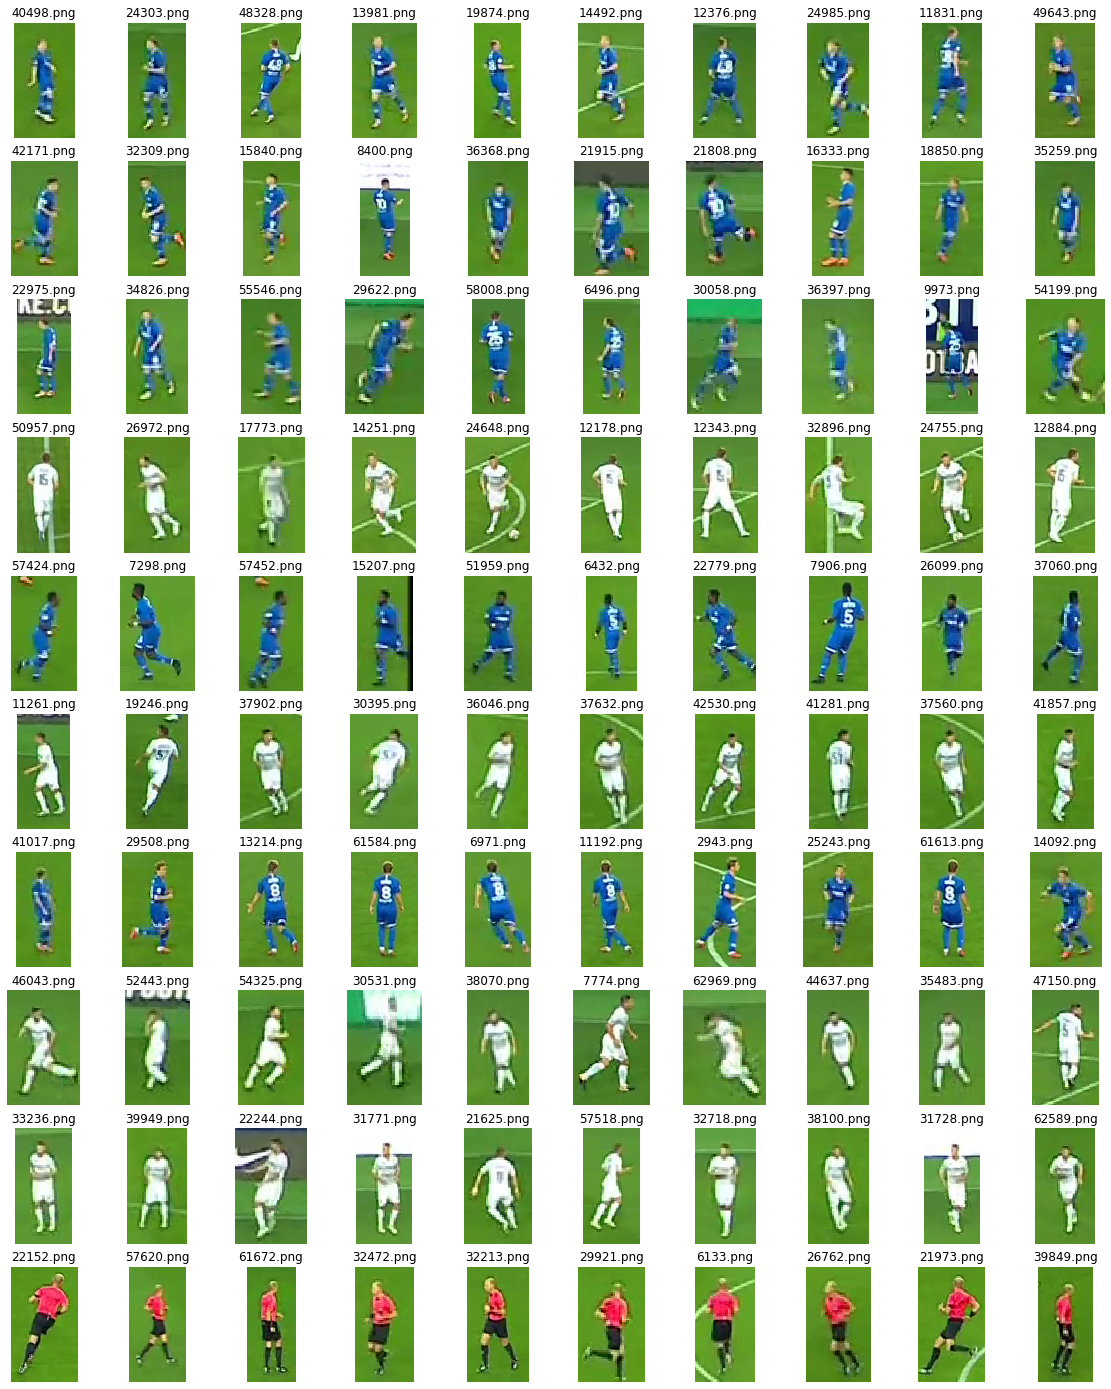

In [7]:
# Для оценки визуализируем часть изображений из датасета

unique_labels = df['label'].unique()
image_samples = {}
for l in unique_labels:
    image_samples[int(l)] = df[df['label'] == l]['boxid'].tolist()

f, axarr = plt.subplots(10,10)
f.set_size_inches(20, 25) 
plt.axis('off')
label_counter = 0
for label, image_names in image_samples.items():
    if label_counter >= 10:
        break
    for image_idx, image_name in enumerate(image_names[:10]):
        axarr[label_counter,image_idx].imshow(load_img(image_name=f'{image_name}.png'))
        axarr[label_counter,image_idx].set_title(f'{image_name}.png')
        axarr[label_counter,image_idx].set_axis_off()
    label_counter+=1

# Конструирование сети

Так как исходные изображения имеют небольшой размер и их количество невелико, то для решения я выбрал ResNet18 с размером входного тензора 128x128x3, числом классов равным 25, dropout 20%. Оптимизатор SGD, Loss - кросс-энтропия.

In [8]:
model = ResNet(input_shape=(128, 128, 3), classes=25, block='basic', repetitions=[2, 2, 2, 2], dropout=0.2)
sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

W0825 15:51:07.618644 140266485479232 deprecation_wrapper.py:119] From /home/artem/anaconda3/envs/keras/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0825 15:51:07.627581 140266485479232 deprecation_wrapper.py:119] From /home/artem/anaconda3/envs/keras/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0825 15:51:07.629465 140266485479232 deprecation_wrapper.py:119] From /home/artem/anaconda3/envs/keras/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0825 15:51:07.645192 140266485479232 deprecation_wrapper.py:119] From /home/artem/anaconda3/envs/keras/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is

reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...


W0825 15:51:09.194664 140266485479232 deprecation_wrapper.py:119] From /home/artem/anaconda3/envs/keras/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



reshaping via a convolution...


Дополнительные настройки параметров сети

In [9]:
img_rows , img_cols = 128, 128
num_classes = 25
batch_size = 32
nb_epoch = 25

filepath = 'football_players_weight.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Подготовка данных

Разделение данных на обучающие и валидационные

In [10]:
def train_test_split(test_size=0.15, val_size=0.15, shuffle=True):
    result = {}
    for label, image_list in image_samples.items():
        train, val, test = [], [], []
        size = len(image_list)
        if shuffle:
            np.random.shuffle(image_list)
        if test_size:
            test = image_list[0: int(test_size * size)]
            image_list = image_list[int(test_size * size):]
        if val_size:
            val = image_list[0: int(val_size * size)]
            image_list = image_list[int(val_size * size):]
        train = image_list
        result[label] = (train, val, test)
    return result

try:
    shutil.rmtree('data', ignore_errors=False)
except:
    pass

try:
    os.mkdir('data')
    os.mkdir(TRAIN)
    os.mkdir(TEST)
    os.mkdir(VAL)
except:
    pass

for label, (train, val, test) in train_test_split().items():
    try:
        os.mkdir(os.path.join(TRAIN, str(label)))
        os.mkdir(os.path.join(TEST, str(label)))
        os.mkdir(os.path.join(VAL, str(label)))
    except:
        pass
    
    for file in train:
        shutil.copy(os.path.join(dataset, f'{file}.png'), os.path.join(TRAIN, str(label), f'{file}.png'))
    for file in test:
        shutil.copy(os.path.join(dataset, f'{file}.png'), os.path.join(TEST, str(label), f'{file}.png'))
    for file in val:
        shutil.copy(os.path.join(dataset, f'{file}.png'), os.path.join(VAL, str(label), f'{file}.png'))

Генераторы для загрузки и предобработки данных

In [11]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.5,
        horizontal_flip=True,
        brightness_range=[0.9, 1.1],

)

val_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory(
            'data/train',
            target_size=(img_rows, img_cols),
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=True
            )

val_set = val_datagen.flow_from_directory(
            'data/val',
            target_size=(img_rows, img_cols),
            batch_size=batch_size,
            class_mode='categorical')

Found 2650 images belonging to 25 classes.
Found 550 images belonging to 25 classes.


Отобразим часть батча из генератора данных для тренировки, чтобы оценить варианты аугментации

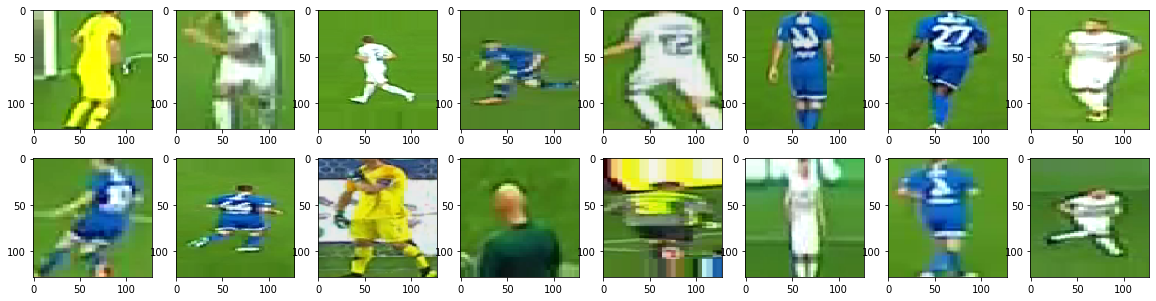

In [12]:
x_batch, y_batch = next(training_set)
f, axarr = plt.subplots(2, 8)
f.set_size_inches(20, 5)
idx = 0
for j in range(2):
    for i in range (0,8):
        image = x_batch[idx*8 + i]
        axarr[idx, i].imshow(image)
    idx += 1

# Обучение сети

In [13]:
model.summary()

model.fit_generator(
        training_set,
        steps_per_epoch=training_set.samples,
        epochs=nb_epoch,
        validation_data=val_set,
        validation_steps=val_set.samples,
        callbacks=callbacks_list,
        use_multiprocessing=True,
        workers=8)

model.save('football_players_model.h5')

W0825 15:51:49.898840 140266485479232 deprecation.py:323] From /home/artem/anaconda3/envs/keras/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 64, 64, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 64, 64, 64)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

/home/artem/anaconda3/envs/keras/lib/python3.7/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


2650/2650 [==============================] - 103s 39ms/step - loss: 2.4821 - acc: 0.4875 - val_loss: 1.9903 - val_acc: 0.6292

Epoch 00001: val_acc improved from -inf to 0.62924, saving model to football_players_weight.hdf5
Epoch 2/25
2650/2650 [==============================] - 100s 38ms/step - loss: 1.7198 - acc: 0.7459 - val_loss: 1.6554 - val_acc: 0.7780

Epoch 00002: val_acc improved from 0.62924 to 0.77803, saving model to football_players_weight.hdf5
Epoch 3/25
2650/2650 [==============================] - 100s 38ms/step - loss: 1.4180 - acc: 0.8516 - val_loss: 1.8242 - val_acc: 0.7644

Epoch 00003: val_acc did not improve from 0.77803
Epoch 4/25
2650/2650 [==============================] - 100s 38ms/step - loss: 1.2784 - acc: 0.8957 - val_loss: 1.4591 - val_acc: 0.8464

Epoch 00004: val_acc improved from 0.77803 to 0.84643, saving model to football_players_weight.hdf5
Epoch 5/25
2650/2650 [==============================] - 100s 38ms/step - loss: 1.1809 - acc: 0.9234 - val_loss: 

# Валидация

Анализ графиков

Text(0.5, 1.0, 'Training and validation accuracy')

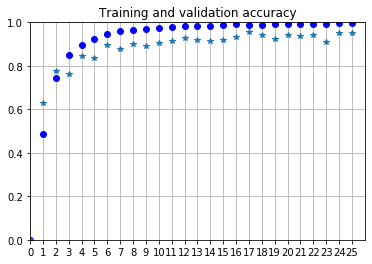

In [43]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            prev = smoothed_points[-1]
            smoothed_points.append(prev * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

acc, val_acc = model.history.history['acc'], model.history.history['val_acc']
plt.plot(list(range(nb_epoch + 1)), [0] + acc, 'bo', label='Training acc')
plt.plot(list(range(nb_epoch + 1)), [0] + val_acc, '*', label='Validation acc')
plt.xlim(0, nb_epoch + 1)
plt.xticks(range(nb_epoch + 1))
plt.ylim(0, 1)
plt.grid()
plt.title('Training and validation accuracy')

In [44]:
val_datagen = ImageDataGenerator(rescale=1./255)
test_gen = val_datagen.flow_from_directory(
            'data/test',
            target_size=(img_rows, img_cols),
            batch_size=batch_size,
            class_mode='categorical')
test_loss, test_acc = model.evaluate_generator(test_gen, steps=test_gen.samples)
test_loss, test_acc

Found 550 images belonging to 25 classes.


(1.0478390774318636, 0.9470273483097199)

# Вывод

Как видно из графика, наилучшую точность на валидации модель получила на 17 эпохе обучения - 95.5%. На итоговом тесте результат получился чуть хуже - 94.7%. Но этот результат близок к валидацинному, а значит сеть обучена корректно.